In [2]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, f1_score, accuracy_score
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
from feature_extractor import FeatureExtractor

def read_jsonl(file_path):
    """Read messages and additional fields from a JSONL file."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def extract_features_from_messages(data):
    """Extract features from a list of messages using FeatureExtractor and include additional fields."""
    feature_extractor = FeatureExtractor()
    features_list = []
    for entry in data:
        # Extract features from the message
        features = feature_extractor.extract_features(entry['message'])
        # Include additional fields as features
        features.update({
            'receiver_annotation': entry['receiver_annotation'],
            'sender_annotation': entry['sender_annotation'],
            'speaker': entry['speaker'],
            'receiver': entry['receiver'],
            'absolute_message_index': entry['absolute_message_index'],
            'relative_message_index': entry['relative_message_index'],
            'season': entry['season'],
            'year': entry['year'],
            'game_score': entry['game_score'],
            'game_score_delta': entry['game_score_delta'],
            'game_id': entry['game_id']
        })
        features_list.append(features)
    return features_list

def create_dataframe(features_list):
    """Create a pandas DataFrame from a list of feature dictionaries."""
    return pd.DataFrame(features_list)

def process_jsonl_to_dataframe(file_path):
    """Process a JSONL file to a pandas DataFrame with extracted features and additional fields."""
    data = read_jsonl(file_path)
    features_list = extract_features_from_messages(data)
    df = create_dataframe(features_list)
    return df

class DataProcessor:
    @staticmethod
    def read_jsonl(file_path):
        """Read messages and additional fields from a JSONL file."""
        data = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                data.append(json.loads(line))
        return data

    @staticmethod
    def preprocess_messages(messages, tokenizer, vocab):
        """Tokenize and convert messages to sequences."""
        return [vocab(tokenizer(message)) for message in messages]

    @staticmethod
    def load_glove_embeddings(glove_path):
        """Load GloVe embeddings from a file."""
        embeddings_index = {}
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        return embeddings_index

    @staticmethod
    def generate_embeddings(vocab, embeddings_index, embedding_dim=50):
        """Generate embedding matrix from vocabulary and GloVe embeddings."""
        embedding_matrix = np.zeros((len(vocab), embedding_dim))
        for word, idx in vocab.get_stoi().items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
        return torch.tensor(embedding_matrix, dtype=torch.float32)

    @staticmethod
    def process_jsonl_to_dataframe(file_path):
        """Convert JSONL data to a DataFrame."""
        data = DataProcessor.read_jsonl(file_path)
        return pd.DataFrame(data)
    
    
class CustomDataset(Dataset):
    def __init__(self, sequences, features, labels):
        self.sequences = sequences
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.features[idx], self.labels[idx]

def collate_fn(batch):
    sequences, features, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    features_stacked = torch.stack(features)
    labels_stacked = torch.stack(labels)
    return sequences_padded, features_stacked, labels_stacked

class CombinedModel(nn.Module):
    def __init__(self, embedding_matrix, num_features, hidden_dim, output_dim):
        super(CombinedModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.fc1 = nn.Linear(embedding_matrix.size(1) + num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, seq, features):
        embedded = self.embedding(seq).mean(dim=1)
        combined = torch.cat((embedded, features), dim=1)
        out = self.fc1(combined)
        out = self.fc2(out)
        return out

class Trainer:
    @staticmethod
    def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
        model.train()
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        train_f1s, val_f1s = [], []

        for epoch in range(num_epochs):
            # Training
            model.train()
            epoch_train_loss = 0
            train_true_labels, train_predicted_labels = [], []

            for seq, features, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(seq, features)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
                train_true_labels.extend(labels.tolist())
                train_predicted_labels.extend(predicted.tolist())

            train_losses.append(epoch_train_loss / len(train_loader))
            train_accuracies.append(accuracy_score(train_true_labels, train_predicted_labels))
            train_f1s.append(f1_score(train_true_labels, train_predicted_labels, average='macro'))

            # Validation
            model.eval()
            epoch_val_loss = 0
            val_true_labels, val_predicted_labels = [], []

            with torch.no_grad():
                for seq, features, labels in val_loader:
                    outputs = model(seq, features)
                    loss = criterion(outputs.squeeze(), labels)
                    epoch_val_loss += loss.item()
                    predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
                    val_true_labels.extend(labels.tolist())
                    val_predicted_labels.extend(predicted.tolist())

            val_losses.append(epoch_val_loss / len(val_loader))
            val_accuracies.append(accuracy_score(val_true_labels, val_predicted_labels))
            val_f1s.append(f1_score(val_true_labels, val_predicted_labels, average='macro'))

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')
            print(f'Train Accuracy: {train_accuracies[-1]}, Val Accuracy: {val_accuracies[-1]}')
            print(f'Train Macro F1: {train_f1s[-1]}, Val Macro F1: {val_f1s[-1]}')
            test_true_labels, test_predicted_labels = Trainer.evaluate_model(model, test_loader)
            print("--- Test Set Classification Report ---")
            print(classification_report(test_true_labels, test_predicted_labels, target_names=['False', 'True']))
            print()

        return model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s

    @staticmethod
    def evaluate_model(model, loader):
        model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for seq, features, labels in loader:
                outputs = model(seq, features)
                probabilities = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
                predicted = (probabilities.squeeze() > 0.5).float()  # Convert to binary predictions
                true_labels.extend(labels.tolist())
                predicted_labels.extend(predicted.tolist())
        return true_labels, predicted_labels

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(train_f1s, label='Train Macro F1')
    plt.plot(val_f1s, label='Val Macro F1')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Execution
# Load and preprocess data
train_data = DataProcessor.read_jsonl('data/train_sm.jsonl')
val_data = DataProcessor.read_jsonl('data/validation_sm.jsonl')
test_data = DataProcessor.read_jsonl('data/test_sm.jsonl')

# Extract features and create DataFrames
train_features_list = extract_features_from_messages(train_data)
val_features_list = extract_features_from_messages(val_data)
test_features_list = extract_features_from_messages(test_data)

train_df = create_dataframe(train_features_list)
val_df = create_dataframe(val_features_list)
test_df = create_dataframe(test_features_list)

# Corrected line: Access shape property without parentheses
print(train_df.shape)

# Prepare features and labels
X_train = train_df.drop('sender_annotation', axis=1)
y_train = train_df['sender_annotation']
X_val = val_df.drop('sender_annotation', axis=1)
y_val = val_df['sender_annotation']
X_test = test_df.drop('sender_annotation', axis=1)
y_test = test_df['sender_annotation']

# One-hot encode categorical features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns
common_cols = list(set(X_train_encoded.columns) & set(X_val_encoded.columns) & set(X_test_encoded.columns))
X_train_encoded = X_train_encoded[common_cols].fillna(0)
X_val_encoded = X_val_encoded[common_cols].fillna(0)
X_test_encoded = X_test_encoded[common_cols].fillna(0)

# Convert boolean columns to integers
bool_columns_train = X_train_encoded.select_dtypes(include=['bool']).columns
bool_columns_val = X_val_encoded.select_dtypes(include=['bool']).columns
bool_columns_test = X_test_encoded.select_dtypes(include=['bool']).columns
X_train_encoded[bool_columns_train] = X_train_encoded[bool_columns_train].astype(int)
X_val_encoded[bool_columns_val] = X_val_encoded[bool_columns_val].astype(int)
X_test_encoded[bool_columns_test] = X_test_encoded[bool_columns_test].astype(int)

# Convert to PyTorch tensors
train_features = torch.tensor(X_train_encoded.values, dtype=torch.float32)
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
val_features = torch.tensor(X_val_encoded.values, dtype=torch.float32)
val_labels = torch.tensor(y_val.values, dtype=torch.float32)
test_features = torch.tensor(X_test_encoded.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.float32)

# Tokenize and preprocess messages
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, [entry['message'] for entry in train_data]), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

train_sequences = DataProcessor.preprocess_messages([entry['message'] for entry in train_data], tokenizer, vocab)
val_sequences = DataProcessor.preprocess_messages([entry['message'] for entry in val_data], tokenizer, vocab)
test_sequences = DataProcessor.preprocess_messages([entry['message'] for entry in test_data], tokenizer, vocab)

# Load GloVe embeddings
glove_path = 'glove.6B/glove.6B.50d.txt'
embeddings_index = DataProcessor.load_glove_embeddings(glove_path)
embedding_matrix = DataProcessor.generate_embeddings(vocab, embeddings_index)

# Convert sequences to tensors
train_sequences = [torch.tensor(seq) for seq in train_sequences]
val_sequences = [torch.tensor(seq) for seq in val_sequences]
test_sequences = [torch.tensor(seq) for seq in test_sequences]

# Create datasets and data loaders
train_dataset = CustomDataset(train_sequences, train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(val_sequences, val_features, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_dataset = CustomDataset(test_sequences, test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(13132, 33)


In [ ]:
# #save the loaders so that we don't have to reprocess the data every time
loader_path = 'data/data_loaders/'
# torch.save(train_loader, loader_path + 'train_loader.pt')
# torch.save(val_loader, loader_path + 'val_loader.pt')
# torch.save(test_loader, loader_path + 'test_loader.pt')

In [ ]:
# Load the data loaders
train_loader = torch.load(loader_path + 'train_loader.pt')
val_loader = torch.load(loader_path + 'val_loader.pt')
test_loader = torch.load(loader_path + 'test_loader.pt')

c:\Users\Akshat\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/9, Train Loss: 0.2980181933619596, Val Loss: 0.059939779341220856
Train Accuracy: 0.6893085592445933, Val Accuracy: 0.8728813559322034
Train Macro F1: 0.44666829593049223, Val Macro F1: 0.5112859805342721
--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.13      0.55      0.21       240
        True       0.94      0.65      0.77      2501

    accuracy                           0.64      2741
   macro avg       0.53      0.60      0.49      2741
weighted avg       0.87      0.64      0.72      2741


Epoch 2/9, Train Loss: 0.06185841782430953, Val Loss: 0.05974889836377568
Train Accuracy: 0.5498020103563813, Val Accuracy: 0.9216101694915254
Train Macro F1: 0.3999796274166745, Val Macro F1: 0.5424745659103147
--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.15      0.43      0.23       240
        True       0.93      0.77      0.85      2501

    a

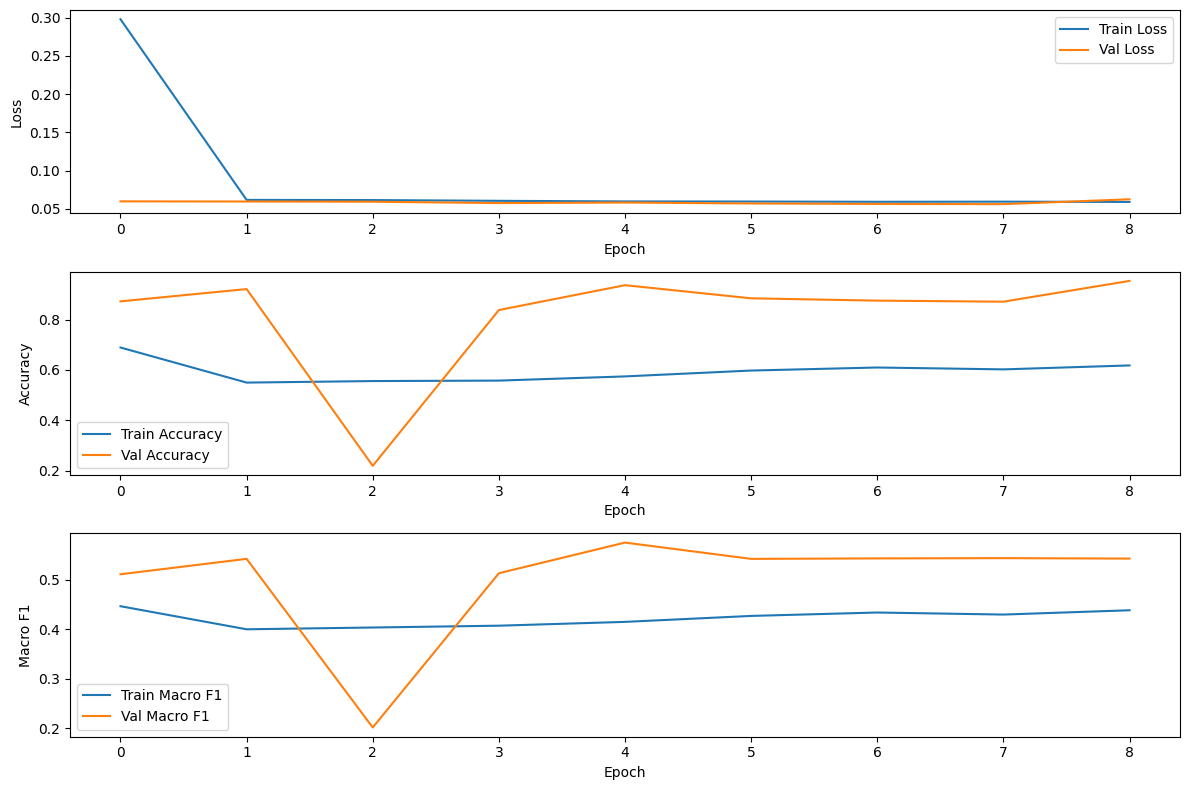

--- Train Set Classification Report ---
              precision    recall  f1-score   support

       False       0.12      0.17      0.14       591
        True       0.96      0.94      0.95     12541

    accuracy                           0.91     13132
   macro avg       0.54      0.55      0.55     13132
weighted avg       0.92      0.91      0.92     13132

--- Validation Set Classification Report ---
              precision    recall  f1-score   support

       False       0.24      0.07      0.11        56
        True       0.96      0.99      0.98      1360

    accuracy                           0.95      1416
   macro avg       0.60      0.53      0.54      1416
weighted avg       0.93      0.95      0.94      1416

--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.30      0.17      0.22       240
        True       0.92      0.96      0.94      2501

    accuracy                           0.89      2741
   m

In [3]:
torch.manual_seed(29)  # For reproducibility

pos_samples = y_train.sum().item()
neg_samples = len(y_train) - pos_samples
pos_weight = torch.tensor([neg_samples / pos_samples])

model = CombinedModel(embedding_matrix, X_train_encoded.shape[1], 128, 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = Trainer.train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=9
)

# Save the model
model_folder = 'Final Models'
torch.save(model.state_dict(), f'{model_folder}/ANN_model.pth')

# Plot training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s)

# Evaluate on train, validation, and test sets
train_true_labels, train_predicted_labels = Trainer.evaluate_model(model, train_loader)
val_true_labels, val_predicted_labels = Trainer.evaluate_model(model, val_loader)
test_true_labels, test_predicted_labels = Trainer.evaluate_model(model, test_loader)

print("--- Train Set Classification Report ---")
print(classification_report(train_true_labels, train_predicted_labels, target_names=['False', 'True']))
print("--- Validation Set Classification Report ---")
print(classification_report(val_true_labels, val_predicted_labels, target_names=['False', 'True']))
print("--- Test Set Classification Report ---")
print(classification_report(test_true_labels, test_predicted_labels, target_names=['False', 'True']))

In [4]:
class CombinedLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, num_features, hidden_dim, output_dim):
        super(CombinedLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embedding_matrix.size(1), hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim + num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, seq, features):
        embedded = self.embedding(seq)  # Shape: (batch_size, seq_len, embedding_dim)
        _, (hidden, _) = self.lstm(embedded)  # Take the hidden state from the last time step
        hidden = hidden.squeeze(0)  # Shape: (batch_size, hidden_dim)
        
        combined = torch.cat((hidden, features), dim=1)  # Combine LSTM output and additional features
        out = self.fc1(combined)
        out = self.fc2(out)
        return out

Epoch 1/18, Train Loss: 2.0913882148357628, Val Loss: 0.3394208681696303
Train Accuracy: 0.9546908315565032, Val Accuracy: 0.9583333333333334
Train Macro F1: 0.48841014453231524, Val Macro F1: 0.48936170212765956
--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       240
        True       0.91      1.00      0.95      2501

    accuracy                           0.91      2741
   macro avg       0.46      0.50      0.48      2741
weighted avg       0.83      0.91      0.87      2741


Epoch 2/18, Train Loss: 0.08726074040441524, Val Loss: 0.06870121972428428
Train Accuracy: 0.5939689308559245, Val Accuracy: 0.346045197740113
Train Macro F1: 0.41495953401451535, Val Macro F1: 0.2842707423580786
--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.11      0.76      0.19       240
        True       0.95      0.42      0.58      2501

    

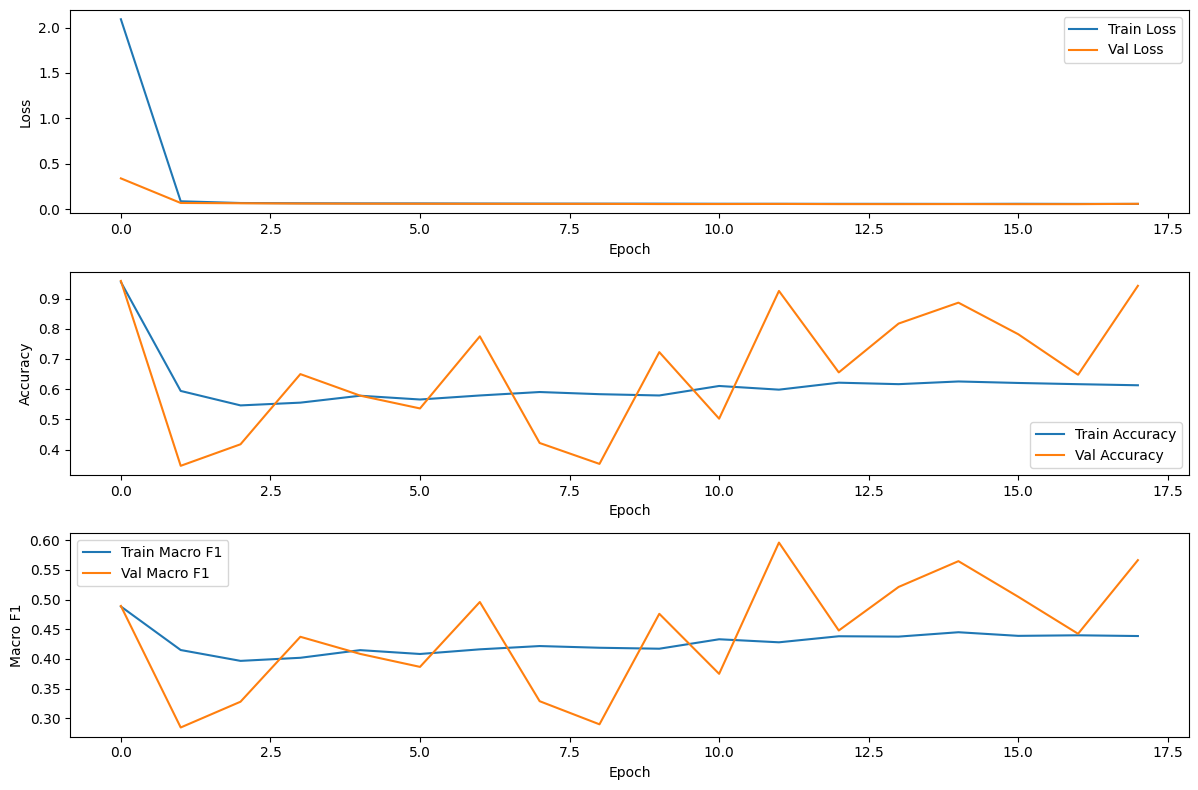

--- Train Set Classification Report ---
              precision    recall  f1-score   support

       False       0.12      0.19      0.15       591
        True       0.96      0.93      0.95     12541

    accuracy                           0.90     13132
   macro avg       0.54      0.56      0.55     13132
weighted avg       0.92      0.90      0.91     13132

--- Validation Set Classification Report ---
              precision    recall  f1-score   support

       False       0.19      0.14      0.16        56
        True       0.97      0.97      0.97      1360

    accuracy                           0.94      1416
   macro avg       0.58      0.56      0.57      1416
weighted avg       0.93      0.94      0.94      1416

--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.29      0.23      0.26       240
        True       0.93      0.95      0.94      2501

    accuracy                           0.88      2741
   m

In [ ]:
torch.manual_seed(29)  # For reproducibility

pos_samples = y_train.sum().item()
neg_samples = len(y_train) - pos_samples
pos_weight = torch.tensor([neg_samples / pos_samples])

model = CombinedLSTMModel(embedding_matrix, X_train_encoded.shape[1], 128, 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = Trainer.train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=18
)

# Save the model
model_folder = 'Final Models'
torch.save(model.state_dict(), f'{model_folder}/combined_lstm_model.pth')

# Plot training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s)

# Evaluate on train, validation, and test sets
train_true_labels, train_predicted_labels = Trainer.evaluate_model(model, train_loader)
val_true_labels, val_predicted_labels = Trainer.evaluate_model(model, val_loader)
test_true_labels, test_predicted_labels = Trainer.evaluate_model(model, test_loader)

print("--- Train Set Classification Report ---")
print(classification_report(train_true_labels, train_predicted_labels, target_names=['False', 'True']))
print("--- Validation Set Classification Report ---")
print(classification_report(val_true_labels, val_predicted_labels, target_names=['False', 'True']))
print("--- Test Set Classification Report ---")
print(classification_report(test_true_labels, test_predicted_labels, target_names=['False', 'True']))

In [13]:
#save the tesst loader
torch.save(test_loader, 'test_loader.pt')

In [12]:
#loading the model for testing
model_test = CombinedLSTMModel(embedding_matrix, X_train_encoded.shape[1], 128, 1)
model_test.load_state_dict(torch.load(f'{model_folder}/combined_lstm_model.pth'))
model_test.eval()
test_true_labels, test_predicted_labels = Trainer.evaluate_model(model_test, test_loader)
print("--- Test Set Classification Report ---")
print(classification_report(test_true_labels, test_predicted_labels, target_names=['False', 'True']))
print(f"Test Accuracy: {accuracy_score(test_true_labels, test_predicted_labels)}")

--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.29      0.23      0.26       240
        True       0.93      0.95      0.94      2501

    accuracy                           0.88      2741
   macro avg       0.61      0.59      0.60      2741
weighted avg       0.87      0.88      0.88      2741

Test Accuracy: 0.883983947464429


In [6]:
import torch
import torch.nn as nn

class CombinedTransformerModel(nn.Module):
    def __init__(self, embedding_matrix, num_features, hidden_dim, output_dim):
        super(CombinedTransformerModel, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        embedding_dim = embedding_matrix.size(1)
        nhead = 5
        
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=nhead, 
            dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)
        self.fc1 = nn.Linear(embedding_dim + num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, seq, features):
        embedded = self.embedding(seq)  # Shape: (batch_size, seq_len, embedding_dim)
        embedded = embedded.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embedding_dim)
        transformer_out = self.transformer(embedded)  # Shape: (seq_len, batch_size, embedding_dim)
        
        # Use the mean of the transformer output as the sequence representation
        transformer_out = transformer_out.mean(dim=0)  # Shape: (batch_size, embedding_dim)
        
        combined = torch.cat((transformer_out, features), dim=1)  # Combine Transformer output and additional features
        out = self.fc1(combined)
        out = self.fc2(out)
        return out

c:\Users\Akshat\anaconda3\envs\nlp\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/11, Train Loss: 1.0249315190815578, Val Loss: 0.07604086533602741
Train Accuracy: 0.22075845263478525, Val Accuracy: 0.5480225988700564
Train Macro F1: 0.20342748502044683, Val Macro F1: 0.3950786056049214
--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.11      0.54      0.19       240
        True       0.93      0.60      0.73      2501

    accuracy                           0.59      2741
   macro avg       0.52      0.57      0.46      2741
weighted avg       0.86      0.59      0.68      2741


Epoch 2/11, Train Loss: 0.07928260269862603, Val Loss: 0.07366589796211985
Train Accuracy: 0.49847700274139506, Val Accuracy: 0.5798022598870056
Train Macro F1: 0.3700138261760663, Val Macro F1: 0.4040298649991688
--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.12      0.50      0.19       240
        True       0.93      0.63      0.75      2501

  

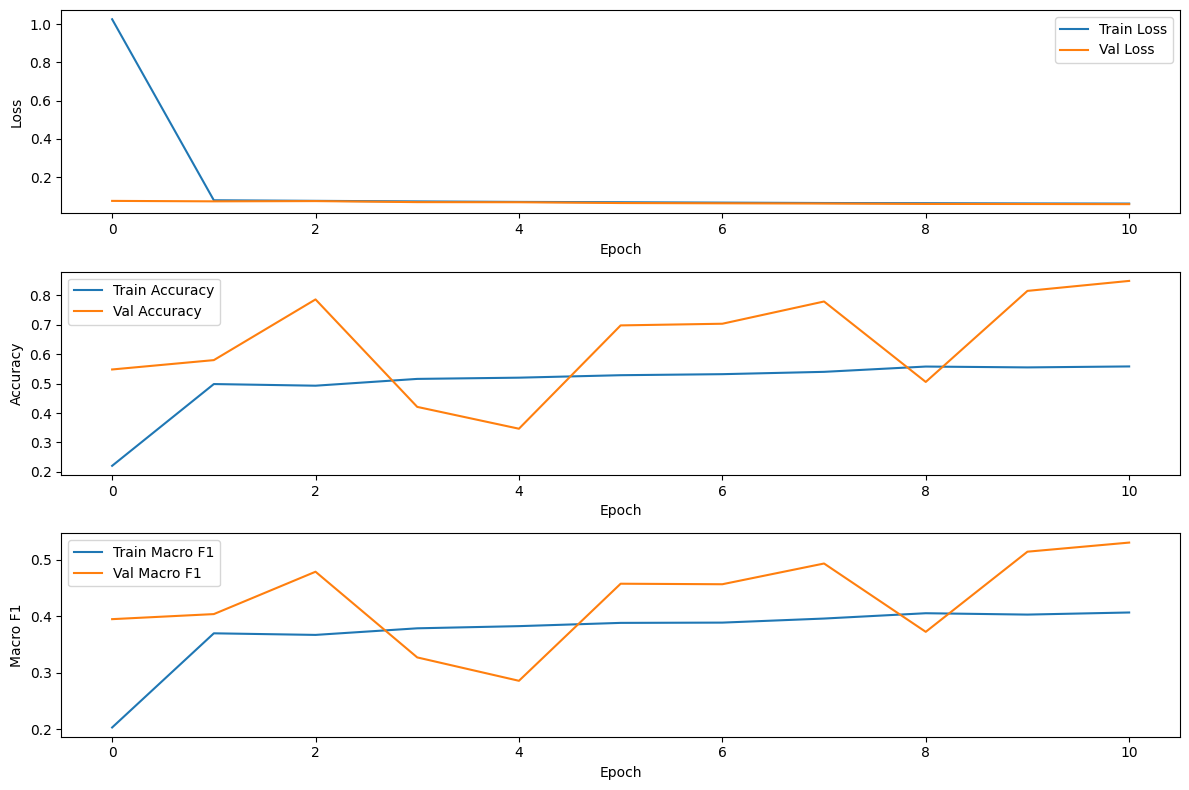

--- Train Set Classification Report ---
              precision    recall  f1-score   support

       False       0.07      0.39      0.12       591
        True       0.96      0.76      0.85     12541

    accuracy                           0.74     13132
   macro avg       0.52      0.58      0.49     13132
weighted avg       0.92      0.74      0.82     13132

--- Validation Set Classification Report ---
              precision    recall  f1-score   support

       False       0.09      0.32      0.14        56
        True       0.97      0.87      0.92      1360

    accuracy                           0.85      1416
   macro avg       0.53      0.60      0.53      1416
weighted avg       0.93      0.85      0.89      1416

--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.15      0.46      0.23       240
        True       0.94      0.75      0.83      2501

    accuracy                           0.73      2741
   m

In [7]:
torch.manual_seed(29)  # For reproducibility

pos_samples = y_train.sum().item()
neg_samples = len(y_train) - pos_samples
pos_weight = torch.tensor([neg_samples / pos_samples])

model = CombinedTransformerModel(embedding_matrix, X_train_encoded.shape[1], 128, 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = Trainer.train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=11
)

# Save the model
model_folder = 'Final Models'
torch.save(model.state_dict(), f'{model_folder}/transformer_model.pth')

# Plot training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s)

# Evaluate on train, validation, and test sets
train_true_labels, train_predicted_labels = Trainer.evaluate_model(model, train_loader)
val_true_labels, val_predicted_labels = Trainer.evaluate_model(model, val_loader)
test_true_labels, test_predicted_labels = Trainer.evaluate_model(model, test_loader)

print("--- Train Set Classification Report ---")
print(classification_report(train_true_labels, train_predicted_labels, target_names=['False', 'True']))
print("--- Validation Set Classification Report ---")
print(classification_report(val_true_labels, val_predicted_labels, target_names=['False', 'True']))
print("--- Test Set Classification Report ---")
print(classification_report(test_true_labels, test_predicted_labels, target_names=['False', 'True']))

In [8]:
model = CombinedLSTMModel(embedding_matrix, X_train_encoded.shape[1], 128, 1)
# Save the model
model_folder = 'Final Models'
torch.load(f'{model_folder}/combined_lstm_model.pth')
test_true_labels, test_predicted_labels = Trainer.evaluate_model(model, test_loader)
print("--- Test Set Classification Report ---")
print(classification_report(test_true_labels, test_predicted_labels, target_names=['False', 'True']))

--- Test Set Classification Report ---
              precision    recall  f1-score   support

       False       0.09      1.00      0.16       240
        True       0.00      0.00      0.00      2501

    accuracy                           0.09      2741
   macro avg       0.04      0.50      0.08      2741
weighted avg       0.01      0.09      0.01      2741



c:\Users\Akshat\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Akshat\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Akshat\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
